[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/soloyant/deltax_workshop_2024/blob/main/tutorials/1_HydrodynamicModeling_ANUGA/[5]ANUGA_model_validation.ipynb)

<div style="text-align: center;">
    <img src="notebook_illustrations/deltax_2020.png" alt="Delta-X Logo" style="height: 100px; width: auto; display: inline;">
    <img src="notebook_illustrations/Tribrand_ColorBlack_rgb_16x3_160601.png" alt="JPL Logo" style="height: 100px; width: auto; display: inline;">
</div>
<h1 style="text-align: center;">Delta-X 2024 Application Workshop - May 8, 2024</h1>
<h2 style="text-align: center;">Anuga Hydrodynamic Modeling: Hands On Exercises</h2>
<h2 style="text-align: center;">Part 5/5: Model Validation</h2>

<h3>Author information:</h3>

Antoine Soloy, Ph.D.  
Division 334F, Caltech - Jet Propulsion Laboratory  
4800 Oak Grove Drive, Pasadena, CA, USA  91109-8099  
Contact: antoine.soloy@jpl.nasa.gov

# I - Import packages and define the working directories

In [1]:
import sys

if 'google.colab' in sys.modules:
  # In case the notebook is opened in google collab, here we download/install all the files we need behind the scenes
  try:
      import os
      os.chdir('/content')
      # Grab workbook files into colab directory
      !git clone https://github.com/soloyant/deltax_workshop_2024.git
      # Install everything using some bash scripts
      !/bin/bash /content/deltax_workshop_2024/tutorials/1_HydrodynamicModeling_ANUGA/utils/anuga_tools/install_anuga_colab.sh
      os.chdir('/content/deltax_workshop_2024/tutorials/1_HydrodynamicModeling_ANUGA/')
  except:
      pass

In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.tri as tri
import geopandas as gpd
import utm
from pyproj import Proj
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from tqdm import notebook
from scipy import interpolate
from scipy.stats import pearsonr
import rasterio as rio

from utils import data_processing_tools as dpt
from utils import data_visualization_tools as viz
from utils import data_validation_tools as val
from utils.anuga_tools import anuga_tools as at

# Import all settings as global variables
if 'google.colab' not in sys.modules:
    from model_inputs.model_settings import *
else:
    from model_inputs.collab.model_settings import *
    
# Define the path to scripts and data
workshop_dir = os.getcwd()
# # Alternatively:
# workshop_dir = '/path/to/1_HydrodynamicModeling_ANUGA'
data_dir = os.path.join(workshop_dir, 'data')
model_inputs_dir = os.path.join(workshop_dir, 'model_inputs')
model_outputs_dir = os.path.join(workshop_dir, 'model_outputs')
if 'google.colab' in sys.modules:
    data_dir = os.path.join(data_dir, 'collab')
    model_inputs_dir = os.path.join(model_inputs_dir, 'collab')
    model_outputs_dir = os.path.join(model_outputs_dir, 'collab')
model_visuals_dir = os.path.join(workshop_dir, 'visuals')
model_validation_dir = os.path.join(workshop_dir, 'validation')
CRMS_dir = os.path.join(data_dir, 'CRMS')

for d in [model_inputs_dir, model_outputs_dir, model_visuals_dir, model_validation_dir]:
    Path(d).mkdir(parents=True, exist_ok=True)
        

# II - Load the saved model output

In [3]:
# First import the domain generated during the DEM processing step
f_domain = os.path.join(data_dir, 'dxws_domain.shp')
domain_gdf = gpd.read_file(f_domain)
domain_polygon = np.asarray(domain_gdf.geometry[0].boundary.xy).T

f_anuga_output = os.path.join(model_outputs_dir, f"{model_name}.sww")
saved_output = nc.Dataset(f_anuga_output)

time = saved_output['time'][:].data
x = saved_output['x'][:].data+saved_output.xllcorner
y = saved_output['y'][:].data+saved_output.yllcorner
friction = saved_output['friction'][:]
N = time.shape[0]
Npt = x.shape[0]

triangles = saved_output['volumes'][:,:].data
triang = tri.Triangulation(x, y, triangles)

print('The loaded model includes '+ str(N)+ ' timesteps and ' + str(Npt) + ' triangles')

The loaded model includes 25 timesteps and 10402 triangles


# III - Tidal input validation
### Datasets citation:
- NOAA (2023). Water levels at Eugene Island, North of, Atchafalaya Bay, LA - 8764314 [Data file], Retrieved from https://tidesandcurrents.noaa.gov/stationhome.html?id=8764314

In [4]:
# Load input tide data
input_tide_ts = pd.read_csv(f_tides)
input_tide_ts['datetime'] = pd.to_datetime(input_tide_ts['datetime'], format="%Y-%m-%d %H:%M:%S")
input_tide_ts['relative_timestamp'] = [input_tide_ts.loc[i,'datetime'].timestamp()-sim_starttime.timestamp() for i in range(input_tide_ts.shape[0])]

In [5]:
# Create a trifinder object to find the triangle index
trifinder = triang.get_trifinder()

# Find the triangle index that contains the point
input_tide_station_tri_ind = trifinder(tide_gauge_ID[2], tide_gauge_ID[3])
    
# Find the points indices of the identified triangle
input_tide_station_xy_ind = triang.triangles[input_tide_station_tri_ind,:]

# Extract predicted water level at station location
sim_wl = np.nanmean(viz.get_output_values(saved_output, 'stage', np.arange(N), input_tide_station_xy_ind), axis=1)

In [6]:
# Resample CRMS data at simulation time
f = interpolate.interp1d(input_tide_ts['relative_timestamp'], 
                         input_tide_ts['water_level'], 
                         kind='linear')
input_tide_wl = f(time)

# Compute validation metrics
r = pearsonr(input_tide_wl, sim_wl)
rmse = np.round(np.sqrt(np.nanmean((sim_wl-input_tide_wl)**2)),2)
mbe = np.round(np.nanmean((sim_wl-input_tide_wl)),2)
r2 = np.round(r[0]**2,2)
pval = format(r[1], '.2')


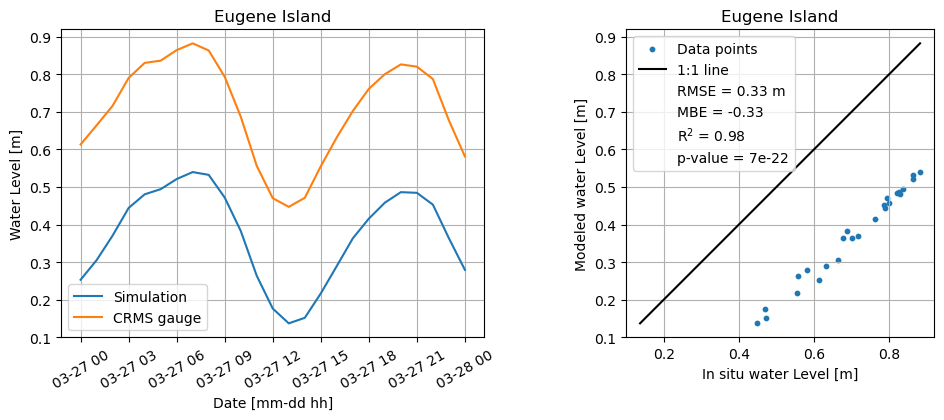

In [7]:
# Data visualization
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,4), dpi=100)
ax1.plot(sim_time, sim_wl, label='Simulation')
ax1.plot(sim_time, input_tide_wl, label='CRMS gauge')
ax1.legend()
ax1.grid('on')
ax1.set_xlabel('Date [mm-dd hh]')
ax1.set_ylabel('Water Level [m]')
ax1.set_title(tide_gauge_ID[1])
for tick in ax1.get_xticklabels():
    tick.set_rotation(30)

ax2.scatter(input_tide_wl, sim_wl, 10, label='Data points')
ax2.plot([np.nanmin([input_tide_wl,sim_wl]), np.nanmax([input_tide_wl,sim_wl])],
         [np.nanmin([input_tide_wl,sim_wl]), np.nanmax([input_tide_wl,sim_wl])],
         label='1:1 line', color='k')
ax2.plot([],[],linewidth=0,label=f"RMSE = {rmse} m")
ax2.plot([],[],linewidth=0,label=f"MBE = {mbe}")
ax2.plot([],[],linewidth=0,label=f"R$^2$ = {r2}")
ax2.plot([],[],linewidth=0,label=f"p-value = {pval}")
ax2.legend()
ax2.grid('on')
ax2.set_xlabel('In situ water Level [m]')
ax2.set_ylabel('Modeled water Level [m]')
ax2.set_title(tide_gauge_ID[1])
ax2.set_aspect('equal', adjustable='box')

plt.savefig(os.path.join(model_validation_dir, 'input_tide_validation.png'))
plt.show()

# IV - Validation with CRMS in situ observations

### Datasets citation:
- Coastal Protection and Restoration Authority (CPRA) of Louisiana. 2024. Coastwide Reference Monitoring System-Wetlands Monitoring Data. Retrieved from Coastal Information Management System (CIMS) database. http://cims.coastal.louisiana.gov. Accessed 24 January 2024

In [8]:
# Import the list of station coordinates
CRMS_locations = pd.read_csv(os.path.join(CRMS_dir, 'CRMS_locations.csv'))

# Identify which stations are located within our model domain
for ii in notebook.tqdm(range(CRMS_locations.shape[0])):
    CRMS_locations.loc[ii, 'is_in_domain'] = Polygon(domain_polygon).contains(Point(CRMS_locations.loc[ii,['x','y']].to_numpy()))

CRMS_locations = CRMS_locations[CRMS_locations.is_in_domain].reset_index(drop=True)

print(CRMS_locations.head)

  0%|          | 0/89 [00:00<?, ?it/s]

<bound method NDFrame.head of    Station_name Station_environment              x             y is_in_domain
0  CRMS0463-H01       Surface_Water  662189.545262  3.263416e+06         True
1  CRMS6304-H01       Surface_Water  666986.757947  3.255835e+06         True>


  0%|          | 0/2 [00:00<?, ?it/s]

Processing CRMS datetimes:   0%|          | 0/147308 [00:00<?, ?it/s]

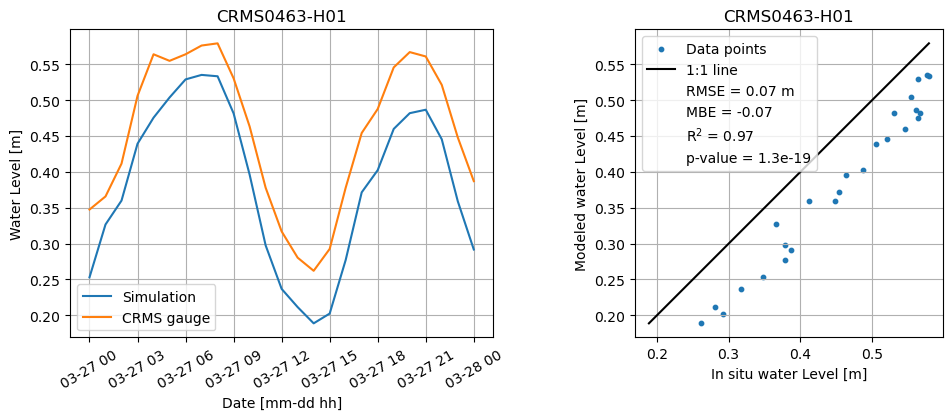

Processing CRMS datetimes:   0%|          | 0/125135 [00:00<?, ?it/s]

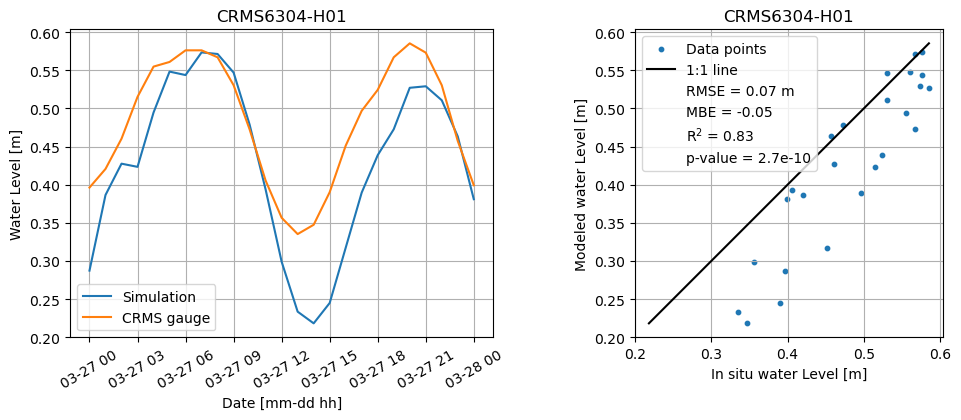

In [9]:
%%capture --no-display

# Extract the water level for each station, and compute the validation metrics
for ii in notebook.tqdm(range(CRMS_locations.shape[0])):
    
    # Load CRMS data
    f_CRMS_station = os.path.join(CRMS_dir, f'time_series/{CRMS_locations.loc[ii, "Station_name"]}.csv')
    CRMS_station_ts = pd.read_csv(f_CRMS_station)
    
    # Process time
    CRMS_station_ts['datetime'] = val.process_CRMS_datetimes(CRMS_station_ts['Date (mm/dd/yyyy)'], CRMS_station_ts['Time (hh:mm:ss)'], CRMS_station_ts['Time Zone'])
    CRMS_station_ts['relative_timestamp'] = [CRMS_station_ts.loc[i,'datetime'].timestamp()-sim_starttime.timestamp() for i in range(CRMS_station_ts.shape[0])]

    try:
    
        # Create a trifinder object to find the triangle index
        trifinder = triang.get_trifinder()
        
        # Find the triangle index that contains the point
        CRMS_station_tri_ind = trifinder(CRMS_locations.loc[ii,'x'], CRMS_locations.loc[ii,'y'])
        
        # Find the points indices of the identified triangle
        CRMS_station_xy_ind = triang.triangles[CRMS_station_tri_ind,:]
        
        # Extract predicted water level at station location
        sim_wl = np.nanmean(viz.get_output_values(saved_output, 'stage', np.arange(N), CRMS_station_xy_ind), axis=1)
        
        # Resample CRMS data at simulation time
        f = interpolate.interp1d(CRMS_station_ts['relative_timestamp'], 
                                 CRMS_station_ts['Adjusted Water Elevation to Datum (m)'], 
                                 # Alternatively, one can try using:
                                 # CRMS_station_ts['Adjusted Water Elevation to Datum Denbina (m)'], 
                                 kind='linear')
        CRMS_wl = f(time)
    
        aligned_ts = pd.DataFrame({'datetime': sim_time, 'CRMS': CRMS_wl, 'sim': sim_wl})
        aligned_ts_nonan = aligned_ts.dropna().reset_index(drop=True)
        
        if aligned_ts_nonan.shape[0]>0:
            r=pearsonr(aligned_ts_nonan['CRMS'], aligned_ts_nonan['sim'])
            CRMS_locations.loc[ii, 'RMSE'] = np.round(np.sqrt(np.nanmean((aligned_ts_nonan['sim']-aligned_ts_nonan['CRMS'])**2)),2)
            CRMS_locations.loc[ii, 'MBE'] = np.round(np.nanmean((aligned_ts_nonan['sim']-aligned_ts_nonan['CRMS'])),2)
            CRMS_locations.loc[ii, 'R2'] = np.round(r[0]**2,2)
            CRMS_locations.loc[ii, 'p-value'] = format(r[1], '.2')
            
            # Data visualization
            fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,4), dpi=100)
            ax1.plot(aligned_ts['datetime'], aligned_ts['sim'], label='Simulation')
            ax1.plot(aligned_ts['datetime'], aligned_ts['CRMS'], label='CRMS gauge')
            ax1.legend()
            ax1.grid('on')
            ax1.set_xlabel('Date [mm-dd hh]')
            ax1.set_ylabel('Water Level [m]')
            ax1.set_title(CRMS_locations.loc[ii, "Station_name"])
            for tick in ax1.get_xticklabels():
                tick.set_rotation(30)
            
            ax2.scatter(aligned_ts_nonan['CRMS'], aligned_ts_nonan['sim'], 10, label='Data points')
            ax2.plot([np.nanmin([aligned_ts_nonan['CRMS'],aligned_ts_nonan['sim']]), np.nanmax([aligned_ts_nonan['CRMS'],aligned_ts_nonan['sim']])],
                     [np.nanmin([aligned_ts_nonan['CRMS'],aligned_ts_nonan['sim']]), np.nanmax([aligned_ts_nonan['CRMS'],aligned_ts_nonan['sim']])],
                     label='1:1 line', color='k')
            ax2.plot([],[],linewidth=0,label=f"RMSE = {CRMS_locations.loc[ii, 'RMSE']} m")
            ax2.plot([],[],linewidth=0,label=f"MBE = {CRMS_locations.loc[ii, 'MBE']}")
            ax2.plot([],[],linewidth=0,label=f"R$^2$ = {CRMS_locations.loc[ii, 'R2']}")
            ax2.plot([],[],linewidth=0,label=f"p-value = {CRMS_locations.loc[ii, 'p-value']}")
            ax2.legend()
            ax2.grid('on')
            ax2.set_xlabel('In situ water Level [m]')
            ax2.set_ylabel('Modeled water Level [m]')
            ax2.set_title(CRMS_locations.loc[ii, "Station_name"])
            ax2.set_aspect('equal', adjustable='box')
    
            plt.savefig(os.path.join(model_validation_dir, f'{CRMS_locations.loc[ii, "Station_name"]}_validation.png'))
            plt.show()
    except:
        pass

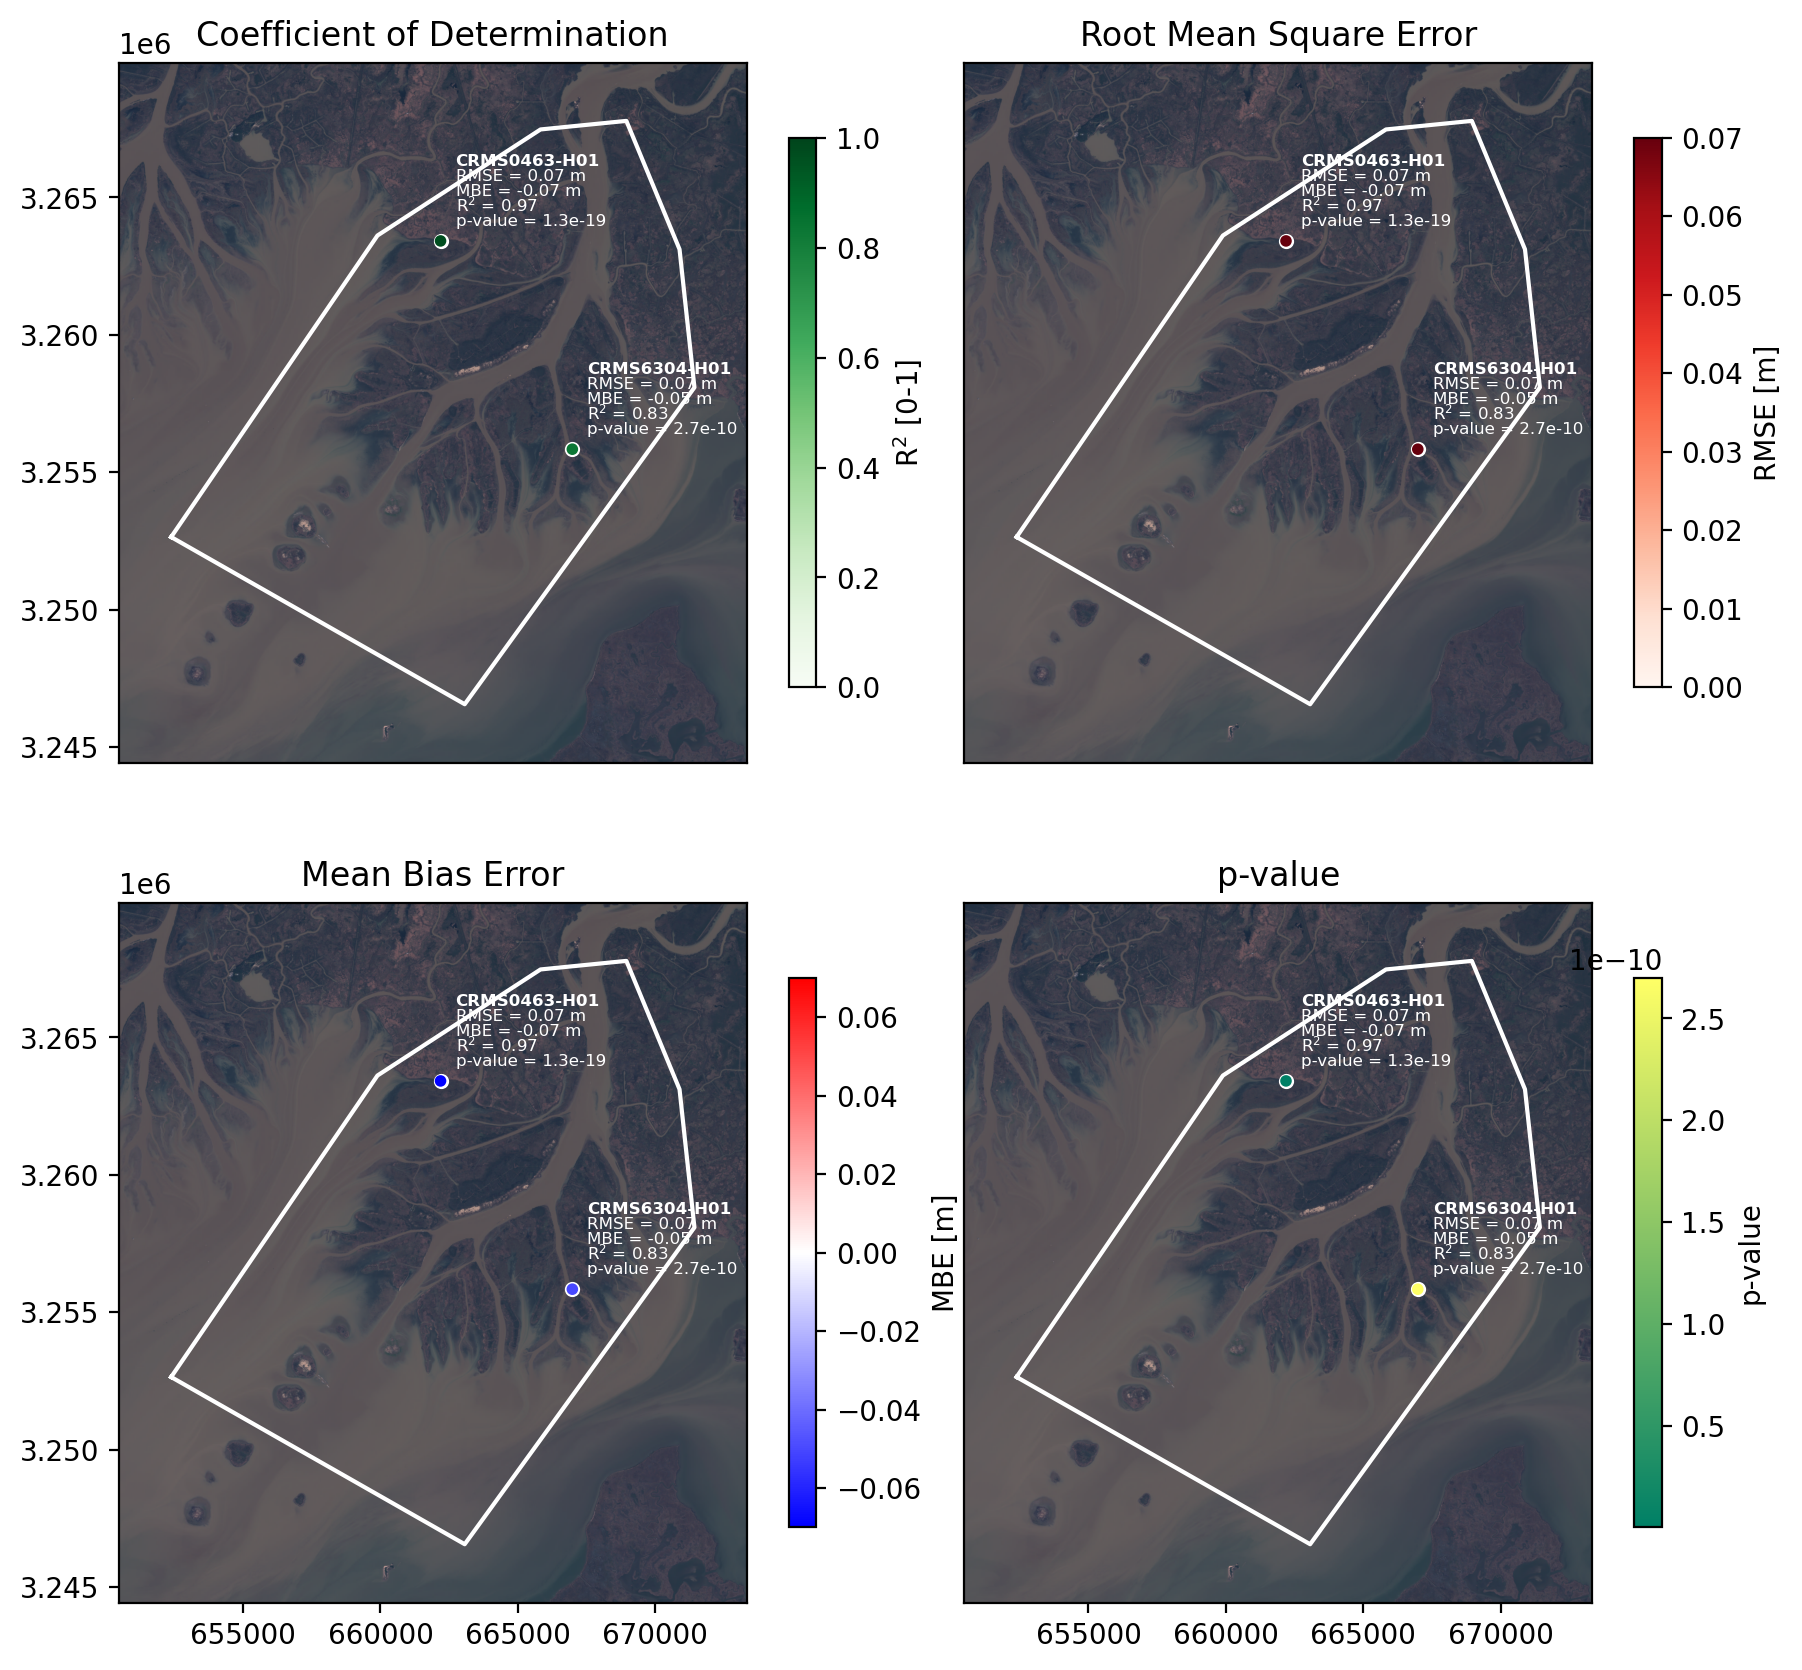

In [10]:
%matplotlib inline

# Data visualization

if 'R2' in CRMS_locations.columns:
    # Background imagery
    f_bg_img_tif = os.path.join(data_dir, 'misissippi_S2_background_image.tif')
    bg_img_src = rio.open(f_bg_img_tif)
    bg_img = np.stack([bg_img_src.read(i) for i in range(1, bg_img_src.count+1)], axis=2)
    bg_img_extent = [bg_img_src.bounds.left, bg_img_src.bounds.right,
                     bg_img_src.bounds.bottom, bg_img_src.bounds.top]
    
    xmin = np.nanmin(domain_polygon[:,0])
    xmax = np.nanmax(domain_polygon[:,0])
    ymin = np.nanmin(domain_polygon[:,1])
    ymax = np.nanmax(domain_polygon[:,1])
    
    fig, ax = plt.subplots(2, 2, figsize=(10, 10), dpi=200)
    offset_px = 15
    ###############################################################
    
    # First frame: R2
    m,n = 0, 0
    ax[m, n].imshow(bg_img, extent=bg_img_extent)
    ax[m, n].plot(domain_polygon[:,0], domain_polygon[:,1], color='white')
    ax[m, n].scatter(CRMS_locations.x, CRMS_locations.y, 20, color='white')
    sc = ax[m, n].scatter(CRMS_locations.x, CRMS_locations.y, 10, CRMS_locations.R2, cmap='Greens', vmin=0, vmax=1)
    trans1 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=5*offset_px, units='dots')
    trans2 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=4*offset_px, units='dots')
    trans3 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=3*offset_px, units='dots')
    trans4 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=2*offset_px, units='dots')
    trans5 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=1*offset_px, units='dots')
    for ii in range(CRMS_locations.shape[0]):
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], CRMS_locations.Station_name[ii], transform=trans1, color='white', fontsize=6, fontweight='bold')
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], f"RMSE = {CRMS_locations.RMSE[ii]} m", transform=trans2, color='white', fontsize=6)
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], f"MBE = {CRMS_locations.MBE[ii]} m", transform=trans3, color='white', fontsize=6)
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], f"R$^2$ = {CRMS_locations.R2[ii]}", transform=trans4, color='white', fontsize=6)
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], f"p-value = {CRMS_locations.loc[ii, 'p-value']}", transform=trans5, color='white', fontsize=6)
    plt.colorbar(sc, fraction=0.039, label='R$^2$ [0-1]')
    ax[m, n].set_title("Coefficient of Determination")
    ax[m, n].axis('scaled')
    ax[m, n].set_xlim([xmin-.1*(xmax-xmin), xmax+.1*(xmax-xmin)])
    ax[m, n].set_ylim([ymin-.1*(ymax-ymin), ymax+.1*(ymax-ymin)])
    ax[m, n].set_xticks([])
    
    
    ###############################################################
    
    # Second frame: RMSE
    m,n = 0, 1
    ax[m, n].imshow(bg_img, extent=bg_img_extent)
    ax[m, n].plot(domain_polygon[:,0], domain_polygon[:,1], color='white')
    ax[m, n].scatter(CRMS_locations.x, CRMS_locations.y, 20, color='white')
    sc = ax[m, n].scatter(CRMS_locations.x, CRMS_locations.y, 10, CRMS_locations.RMSE, cmap='Reds', vmin=0, vmax=np.nanmax(CRMS_locations.RMSE))
    trans1 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=5*offset_px, units='dots')
    trans2 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=4*offset_px, units='dots')
    trans3 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=3*offset_px, units='dots')
    trans4 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=2*offset_px, units='dots')
    trans5 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=1*offset_px, units='dots')
    for ii in range(CRMS_locations.shape[0]):
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], CRMS_locations.Station_name[ii], transform=trans1, color='white', fontsize=6, fontweight='bold')
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], f"RMSE = {CRMS_locations.RMSE[ii]} m", transform=trans2, color='white', fontsize=6)
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], f"MBE = {CRMS_locations.MBE[ii]} m", transform=trans3, color='white', fontsize=6)
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], f"R$^2$ = {CRMS_locations.R2[ii]}", transform=trans4, color='white', fontsize=6)
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], f"p-value = {CRMS_locations.loc[ii, 'p-value']}", transform=trans5, color='white', fontsize=6)
    plt.colorbar(sc, fraction=0.039, label='RMSE [m]')
    ax[m, n].set_title("Root Mean Square Error")
    ax[m, n].axis('scaled')
    ax[m, n].set_xlim([xmin-.1*(xmax-xmin), xmax+.1*(xmax-xmin)])
    ax[m, n].set_ylim([ymin-.1*(ymax-ymin), ymax+.1*(ymax-ymin)])
    ax[m, n].set_xticks([])
    ax[m, n].set_yticks([])
    
    ###############################################################
    
    # Third frame: MBE
    m,n = 1, 0
    ax[m, n].imshow(bg_img, extent=bg_img_extent)
    ax[m, n].plot(domain_polygon[:,0], domain_polygon[:,1], color='white')
    ax[m, n].scatter(CRMS_locations.x, CRMS_locations.y, 20, color='white')
    sc = ax[m, n].scatter(CRMS_locations.x, CRMS_locations.y, 10, CRMS_locations.MBE, cmap='bwr', 
                          vmin=-np.nanmax(np.abs(CRMS_locations.MBE)), vmax=np.nanmax(np.abs(CRMS_locations.MBE)))
    trans1 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=5*offset_px, units='dots')
    trans2 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=4*offset_px, units='dots')
    trans3 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=3*offset_px, units='dots')
    trans4 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=2*offset_px, units='dots')
    trans5 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=1*offset_px, units='dots')
    for ii in range(CRMS_locations.shape[0]):
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], CRMS_locations.Station_name[ii], transform=trans1, color='white', fontsize=6, fontweight='bold')
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], f"RMSE = {CRMS_locations.RMSE[ii]} m", transform=trans2, color='white', fontsize=6)
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], f"MBE = {CRMS_locations.MBE[ii]} m", transform=trans3, color='white', fontsize=6)
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], f"R$^2$ = {CRMS_locations.R2[ii]}", transform=trans4, color='white', fontsize=6)
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], f"p-value = {CRMS_locations.loc[ii, 'p-value']}", transform=trans5, color='white', fontsize=6)
    plt.colorbar(sc, fraction=0.039, label='MBE [m]')
    ax[m, n].set_title("Mean Bias Error")
    ax[m, n].axis('scaled')
    ax[m, n].set_xlim([xmin-.1*(xmax-xmin), xmax+.1*(xmax-xmin)])
    ax[m, n].set_ylim([ymin-.1*(ymax-ymin), ymax+.1*(ymax-ymin)])
    
    ###############################################################
    
    # Forth frame: p-value
    m,n = 1, 1
    ax[m, n].imshow(bg_img, extent=bg_img_extent)
    ax[m, n].plot(domain_polygon[:,0], domain_polygon[:,1], color='white')
    ax[m, n].scatter(CRMS_locations.x, CRMS_locations.y, 20, color='white')
    sc = ax[m, n].scatter(CRMS_locations.x, CRMS_locations.y, 10, CRMS_locations['p-value'].astype(float), cmap='summer', 
                          vmin=np.nanmin(CRMS_locations['p-value'].astype(float)), vmax=np.nanmax(CRMS_locations['p-value'].astype(float)))
    trans1 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=5*offset_px, units='dots')
    trans2 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=4*offset_px, units='dots')
    trans3 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=3*offset_px, units='dots')
    trans4 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=2*offset_px, units='dots')
    trans5 = transforms.offset_copy(ax[m,n].transData, fig=fig, x=offset_px, y=1*offset_px, units='dots')
    for ii in range(CRMS_locations.shape[0]):
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], CRMS_locations.Station_name[ii], transform=trans1, color='white', fontsize=6, fontweight='bold')
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], f"RMSE = {CRMS_locations.RMSE[ii]} m", transform=trans2, color='white', fontsize=6)
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], f"MBE = {CRMS_locations.MBE[ii]} m", transform=trans3, color='white', fontsize=6)
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], f"R$^2$ = {CRMS_locations.R2[ii]}", transform=trans4, color='white', fontsize=6)
        ax[m, n].text(CRMS_locations.x[ii], CRMS_locations.y[ii], f"p-value = {CRMS_locations.loc[ii, 'p-value']}", transform=trans5, color='white', fontsize=6)
    plt.colorbar(sc, fraction=0.039, label='p-value')
    ax[m, n].set_title("p-value")
    ax[m, n].axis('scaled')
    ax[m, n].set_xlim([xmin-.1*(xmax-xmin), xmax+.1*(xmax-xmin)])
    ax[m, n].set_ylim([ymin-.1*(ymax-ymin), ymax+.1*(ymax-ymin)])
    ax[m, n].set_yticks([])
    
    plt.savefig(os.path.join(model_validation_dir, 'CRMS_validation_maps.png'))
    plt.show()
else: 
    print('Sorry, all CRMS stations found within your model domain had insufficient data for to allow perform validation')

# V - plt.savefig('books_read.png')Validation with AirSWOT remote sensing observations

### Datasets citation:
- Denbina, M.W., M. Simard, and E. Rodriguez. 2024. Delta-X: AirSWOT L3 Water Surface Elevations, MRD, Louisiana, 2021, V2. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/2349

In [11]:
# Load AirSWOT datasets
airswot_dir = os.path.join(data_dir, 'DeltaX_L3_AirSWOT_WaterElev_V2_2349/data')
airswot_files_list = [file for file in os.listdir(airswot_dir) if file.endswith('.csv')]

for file in airswot_files_list:
    if file==airswot_files_list[0]:
        airswot_data = pd.read_csv(os.path.join(airswot_dir, file))
    else:
        airswot_data_i = pd.read_csv(os.path.join(airswot_dir, file))
        airswot_data = pd.concat([airswot_data, airswot_data_i])
airswot_data = airswot_data.dropna().reset_index(drop=True)

In [12]:
# Process date and times
airswot_data['datetime'] = pd.to_datetime(airswot_data['date'] + ' ' + airswot_data['time'], format='%Y-%m-%d %H:%M:%S', utc=True)

In [13]:
# Identify AirSWOT measurements within the model domain and simulation time 
for ii in notebook.tqdm(range(airswot_data.shape[0])):
    airswot_data.loc[ii, 'is_within_domain'] = Polygon(domain_polygon).contains(Point(airswot_data.loc[ii,['CoordX','CoordY']].to_numpy()))
    airswot_data.loc[ii, 'is_within_sim_time'] = np.logical_and(airswot_data.loc[ii,'datetime']>=sim_starttime, airswot_data.loc[ii,'datetime']<=sim_endtime)

airswot_data = airswot_data[np.logical_and(airswot_data['is_within_domain'], airswot_data['is_within_sim_time'])].reset_index(drop=True)

print(f"There are {airswot_data.shape[0]} AirSWOT data points within the model domain and simulation time")

  0%|          | 0/4179 [00:00<?, ?it/s]

There are 94 AirSWOT data points within the model domain and simulation time


In [14]:
%%capture --no-display

# Identidy the mesh cells corresponding to AirSWOT sampling points
trifinder = triang.get_trifinder()
airswot_data['tri_ind'] = trifinder(airswot_data['CoordX'], airswot_data['CoordY'])
airswot_data[['pt1_ind', 'pt2_ind', 'pt3_ind']] = triang.triangles[airswot_data['tri_ind'],:]

# Extract simulated water levels at AirSWOT sampling points
for ii in range(airswot_data.shape[0]):
    dt = airswot_data.loc[ii,'datetime']-np.array([pd.Timestamp(st, tz='UTC') for st in sim_time])
    dt_sec = [dts.total_seconds() for dts in dt]
    airswot_data['nearest_sim_time'] = np.where(np.abs(dt_sec)==np.nanmin(np.abs(dt_sec)))[0][0]
airswot_data['sim_wl'] = [np.nanmean(viz.get_output_values(saved_output, 'stage', airswot_data.loc[i,'nearest_sim_time'], airswot_data[['pt1_ind', 'pt2_ind', 'pt3_ind']].values[i])) for i in range(airswot_data.shape[0])]


In [15]:
# Compute the model prediction error
airswot_data['sim_error'] = airswot_data['sim_wl']-airswot_data['water_surface_elevation_NAVD88']

# Compute validation metrics
r = pearsonr(airswot_data['water_surface_elevation_NAVD88'], airswot_data['sim_wl'])
rmse = np.round(np.sqrt(np.nanmean((airswot_data['sim_error'])**2)),2)
mbe = np.round(np.nanmean((airswot_data['sim_error'])),2)
r2 = np.round(r[0]**2,2)
pval = format(r[1], '.2')


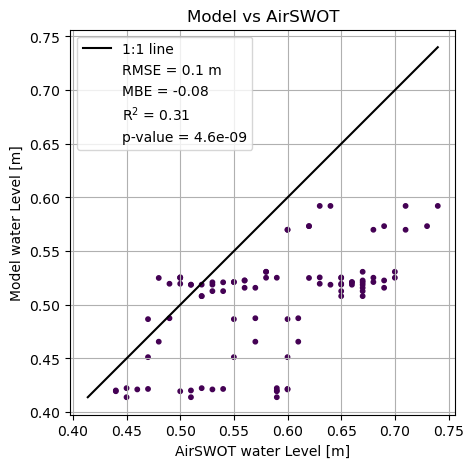

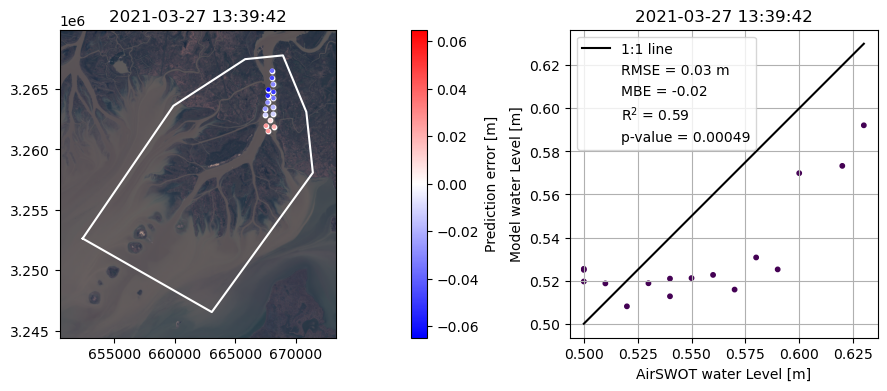

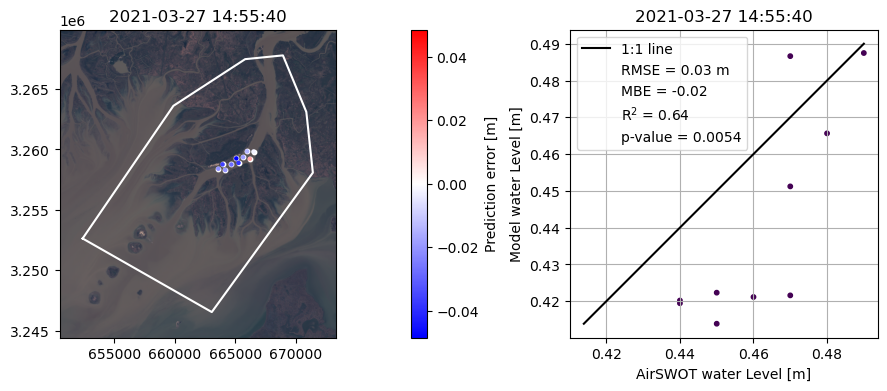

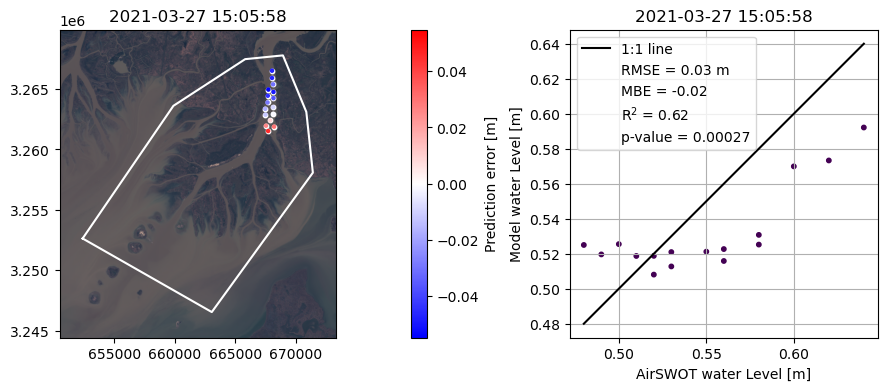

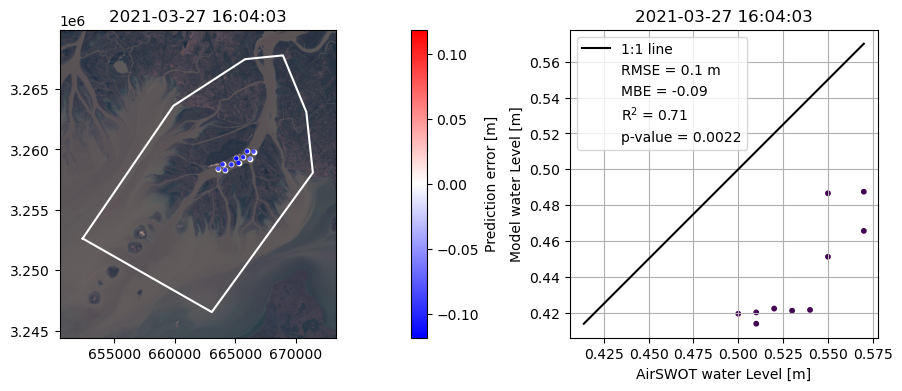

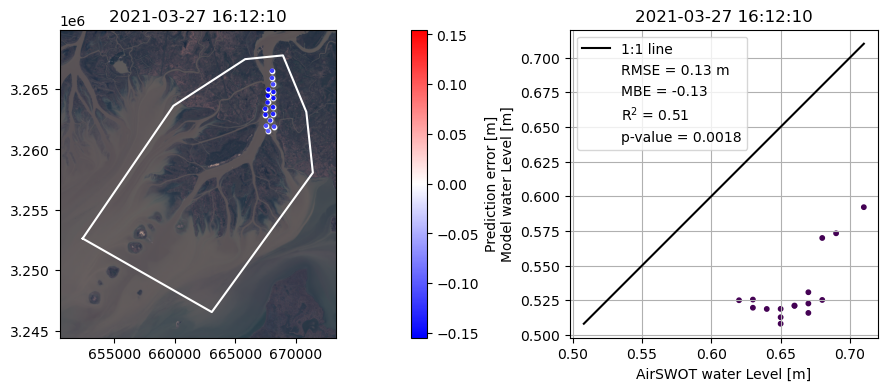

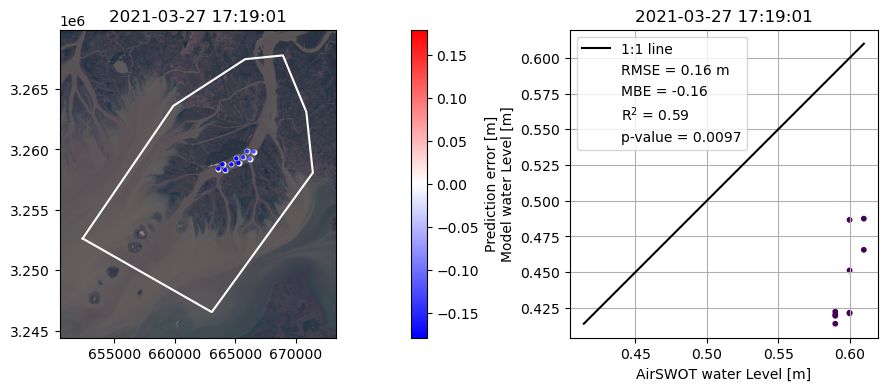

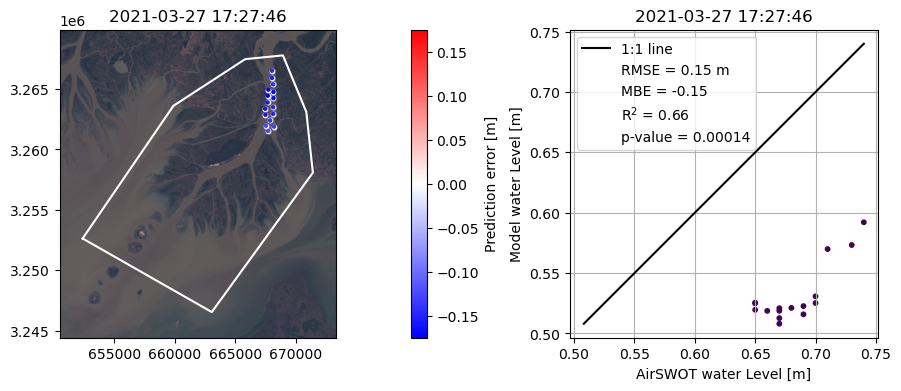

In [16]:
# Data visualization
fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=100)

ax.scatter(airswot_data['water_surface_elevation_NAVD88'], 
            airswot_data['sim_wl'], 10,
            c=airswot_data['water_surface_elevation_uncertainty'])
ax.plot([np.nanmin([airswot_data['water_surface_elevation_NAVD88'], airswot_data['sim_wl']]), 
         np.nanmax([airswot_data['water_surface_elevation_NAVD88'], airswot_data['sim_wl']])],
         [np.nanmin([airswot_data['water_surface_elevation_NAVD88'], airswot_data['sim_wl']]), 
          np.nanmax([airswot_data['water_surface_elevation_NAVD88'], airswot_data['sim_wl']])],
         label='1:1 line', color='k')
ax.plot([],[],linewidth=0,label=f"RMSE = {rmse} m")
ax.plot([],[],linewidth=0,label=f"MBE = {mbe}")
ax.plot([],[],linewidth=0,label=f"R$^2$ = {r2}")
ax.plot([],[],linewidth=0,label=f"p-value = {pval}")
ax.legend()
ax.grid('on')
ax.set_xlabel('AirSWOT water Level [m]')
ax.set_ylabel('Model water Level [m]')
ax.set_title('Model vs AirSWOT')
ax.set_aspect('equal', adjustable='box')

plt.savefig(os.path.join(model_validation_dir, 'AirSWOT_validation.png'))
plt.show()

for ti in np.unique(airswot_data['datetime']):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,4), dpi=100)
    airswot_data_subset = airswot_data[airswot_data['datetime']==ti].reset_index(drop=True)
    
    ax1.imshow(bg_img, extent=bg_img_extent)
    ax1.plot(domain_polygon[:,0], domain_polygon[:,1], color='white')
    ax1.scatter(airswot_data_subset['CoordX'], airswot_data_subset['CoordY'], 10, color='white')
    sc = ax1.scatter(airswot_data_subset['CoordX'], airswot_data_subset['CoordY'], 5, airswot_data_subset['sim_error'], 
                     vmin=-np.nanmax(np.abs(airswot_data_subset['sim_error'])), 
                     vmax=np.nanmax(np.abs(airswot_data_subset['sim_error'])), 
                     cmap='bwr')
    plt.colorbar(sc, fraction=0.039, label='Prediction error [m]')
    ax1.set_title(str(ti)[:-6])
    ax1.axis('scaled')
    ax1.set_xlim([xmin-.1*(xmax-xmin), xmax+.1*(xmax-xmin)])
    ax1.set_ylim([ymin-.1*(ymax-ymin), ymax+.1*(ymax-ymin)])

    # Compute validation metric of subset
    r_subset = pearsonr(airswot_data_subset['water_surface_elevation_NAVD88'], airswot_data_subset['sim_wl'])
    rmse_subset = np.round(np.sqrt(np.nanmean((airswot_data_subset['sim_error'])**2)),2)
    mbe_subset = np.round(np.nanmean((airswot_data_subset['sim_error'])),2)
    r2_subset = np.round(r_subset[0]**2,2)
    pval_subset = format(r_subset[1], '.2')

    ax2.scatter(airswot_data_subset['water_surface_elevation_NAVD88'], 
                airswot_data_subset['sim_wl'], 10,
                c=airswot_data_subset['water_surface_elevation_uncertainty'])
    ax2.plot([np.nanmin([airswot_data_subset['water_surface_elevation_NAVD88'], airswot_data_subset['sim_wl']]), 
             np.nanmax([airswot_data_subset['water_surface_elevation_NAVD88'], airswot_data_subset['sim_wl']])],
             [np.nanmin([airswot_data_subset['water_surface_elevation_NAVD88'], airswot_data_subset['sim_wl']]), 
              np.nanmax([airswot_data_subset['water_surface_elevation_NAVD88'], airswot_data_subset['sim_wl']])],
             label='1:1 line', color='k')
    ax2.plot([],[],linewidth=0,label=f"RMSE = {rmse_subset} m")
    ax2.plot([],[],linewidth=0,label=f"MBE = {mbe_subset}")
    ax2.plot([],[],linewidth=0,label=f"R$^2$ = {r2_subset}")
    ax2.plot([],[],linewidth=0,label=f"p-value = {pval_subset}")
    ax2.legend()
    ax2.grid('on')
    ax2.set_xlabel('AirSWOT water Level [m]')
    ax2.set_ylabel('Model water Level [m]')
    ax2.set_title(str(ti)[:-6])
    ax2.set_aspect('equal', adjustable='box')

    plt.savefig(os.path.join(model_validation_dir, f'AirSWOT_{str(ti)[:-6]}_validation.png'))
    plt.show()